# **Projeto Airbnb RJ** - Ferramenta para Previsão da Diária de um Imóvel

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo do Projeto

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### Fonte dos dados

- As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro
- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Ponderações Iniciais no Projeto

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

A ideia do projeto é entender como esses fatores impactam no preço da diária e se temos outros fatores não tão intuitivos que são extremamente importantes.

## 1) Bibliotecas usadas

In [1]:
import pandas as pd
import pathlib        # Para percorrer os arquivos que tem dentro de uma pasta do computador, assim podemos abril todos os arquivos da pasta dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor            # Modelos de arvore de decisão vem da biblioteca sklearn.ensemble
from sklearn.model_selection import train_test_split

## 2) Transformando Base de Dados em dataframe

In [2]:
caminho_bases = pathlib.Path('../dados/dataset')
bases = []

meses = {'jan': 1, 'fev': 2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7, 'ago':8, 'set':9, 'out':10, 'nov':11, 'dez':12}

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[0:3]
    mes = meses[nome_mes]
    ano = arquivo.name[-8:]                       # Pegando as ultimas 8 letras do nome do arquivo, reparar que contém o .csv dentro do nome
    ano = int(ano.replace('.csv', ''))
        
    df = pd.read_csv(caminho_bases / arquivo.name)    # outra maneira: df = pd.read_csv(r'dataset\{}'.format(arquivo.name))  
    
    df['ano'] = ano                                   # Adicionando a coluna 'ano' em que todos os valores são o ano conforme nome do arquivo
    df['mes'] = mes                                   # Não esquecer de deixar o df['mes'] entre parenteses, se não criará 1 coluna pra cada mês
    
    bases.append(df)                                  # Juntamos os arquivos numa lista comum do python

base_airbnb = pd.concat(bases)                        # Usamos o comando pd.concat(lista) para converter num dataframe do pandas 

display(base_airbnb)

C:\Users\brcprrcchave\AppData\Local\Temp\ipykernel_20256\2434095479.py:12: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)    # outra maneira: df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
C:\Users\brcprrcchave\AppData\Local\Temp\ipykernel_20256\2434095479.py:12: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)    # outra maneira: df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
C:\Users\brcprrcchave\AppData\Local\Temp\ipykernel_20256\2434095479.py:12: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)    # outra maneira: df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
C:\Users\brcprrcchave\AppData\Local\Temp\ipykernel_20256\2434095479.py:12: DtypeWarning: Co

id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

## 3) Tratamento dos dados da base

#### Listando todas as colunas para identificar quais colunas irei excluir

In [3]:
print(list(base_airbnb.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

Critérios para excluir colunas que não são necessárias para o modelo de machine learning
- ID's, Links para sites e informações não relevantes para o modelo
- Colunas com texto livre (nome, resumo, descrição do espaço, etc) - pois não será usado nenhum modelo de análise de palavras
- Colunas com informações repetidas
- Colunas em que todos ou quase todos os valores são iguais
- Muitas colunas sobre o mesmo tema (localização por exemplo, podemos deixar apenas latitude e longitude)
- Coluna iD (para que os modelos de machine learning não interpretem esse valor como uma variável)

In [4]:
# Gerando um arquivo .csv para analisarmos pelo excel quais colunas iremos excluir e quais iremos manter no dataframe

base_airbnb.head(1000).to_csv('../dados/primeiros1000registros.csv', sep=';')

In [5]:
# Verificar quantas informações temos numa coluna 'experiences_offered' --> Se todos valores forem igual podemos deletar a coluna inteira
base_airbnb[['experiences_offered']].value_counts()

experiences_offered
none                   902210
Name: count, dtype: int64

In [6]:
# Verificando se as 2 linhas abaixo são iguais (ou quase)
print((base_airbnb['host_listings_count']==base_airbnb['host_total_listings_count']).value_counts())

True     901750
False       460
Name: count, dtype: int64


In [7]:
# Verificando a quantidade de valores nulos na coluna 'square_feet', se for significativa não usarei na análise
print(base_airbnb['square_feet'].isnull().sum())

888162


#### Definindo quais colunas iremos manter no dataframe deste projeto

In [8]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]                 
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Tratando Valores Nulos

3 Possíveis critérios de tratamento dos dados:
- Excluir as linhas que os valores são nulos
- Colocar algum valor nas linhas que tem algum valor nulo (mediana ou média, ou algum valor zero se estiver relacionado a uma taxa adicional, por exemplo)
- Excluir a coluna inteira caso o número de valores vazios seja elevado (mais 300 mil valores nulos, representa que naquela coluna um terço dos valores são nulos aproximadamente)

In [9]:
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

#### Excluindo colunas cujo número de valores nulos supera 300 mil

In [10]:
for coluna in base_airbnb:                                         
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64
(902210, 23)


#### Excluindo todas as linhas com valores nulos

In [11]:
base_airbnb = base_airbnb.dropna()
base_airbnb.shape

(897709, 23)

#### Verificando a não existência de valores nulos

In [12]:
print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificando Tipos de Dados em cada coluna

In [13]:
print(base_airbnb.dtypes)
print("-"*60)
base_airbnb.iloc[0]

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------


host_is_superhost                                                           f
host_listings_count                                                       1.0
latitude                                                           -22.946854
longitude                                                          -43.182737
property_type                                                       Apartment
room_type                                                     Entire home/apt
accommodates                                                                4
bathrooms                                                                 1.0
bedrooms                                                                  0.0
beds                                                                      2.0
bed_type                                                             Real Bed
amenities                   {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                                           

#### Corrigindo os valores da coluna "price" e "extra_people" para valores numerícos, tipo de dado mais adequado para os modelos de Machine Learning

In [14]:
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')

base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')

In [15]:
base_airbnb[['price', 'extra_people']]

price extra_people
0      133.00        34.00
1      270.00        51.00
2      222.00       215.00
3      161.00        45.00
4      222.00        68.00
...       ...          ...
34324  121.00        50.00
34325  799.00         0.00
34326  420.00        30.00
34327  250.00         0.00
34328   92.00        80.00

[897709 rows x 2 columns]

In [16]:
base_airbnb[['price', 'extra_people']].dtypes

price           object
extra_people    object
dtype: object

In [17]:
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)                  # Usar o comando .astype(np.float32)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)    # O np.float32 ocupa menos espaço de memória do que o np.float
base_airbnb[['price', 'extra_people']].dtypes

price           float32
extra_people    float32
dtype: object

## 4) Análise Exploratória e Tratamento de Outliers

**Como será feita a análise**:

- Será avaliado coluna por coluna para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features / colunas.
    2. Excluir outliers (usarei como regra a exclusão de valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude, sendo a Amplitude = Q3 - Q1)
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir a coluna do dataframe

**Sequência:**
-   a) Será avaliado primeiro as colunas com valores numéricos contínuos (colunas 'price' e coluna 'extra_people', que são valores monetários).
-   b) Em seguida será analisado as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)
-   c) Depois, será avaliado  as colunas de texto para definir quais categorias faz sentido manter na análise (podemos ter muitas categorias com baixa representatividade nos dados).
-   d) Por fim, será avaliado variáveis geográficas (latitude e longitude)

In [18]:
print(base_airbnb.corr(numeric_only=True))          # Não esquecer de passar o parametro numeric_only=True dentro do .corr() se não dará erro

                     host_listings_count  latitude  longitude  accommodates  \
host_listings_count             1.000000 -0.034115   0.063635      0.069320   
latitude                       -0.034115  1.000000   0.370416     -0.142082   
longitude                       0.063635  0.370416   1.000000     -0.121746   
accommodates                    0.069320 -0.142082  -0.121746      1.000000   
bathrooms                       0.022332 -0.169135  -0.170504      0.521909   
bedrooms                        0.039712 -0.165050  -0.186332      0.675913   
beds                            0.042788 -0.113931  -0.110392      0.692740   
price                           0.092306 -0.092437  -0.085526      0.269929   
guests_included                 0.041932 -0.091123   0.049375      0.317563   
extra_people                   -0.031589 -0.041113   0.001723      0.078709   
minimum_nights                 -0.006441 -0.016090  -0.019213      0.024583   
maximum_nights                 -0.000100 -0.001386  

### Análise gráfica das correlações entre todas as features

In [19]:
import plotly.express as px

fig = px.imshow(base_airbnb.corr(numeric_only=True), text_auto=".3f", color_continuous_scale='Greens')   #text_auto=True, 
fig.update_layout(width=1000, height=1000)
fig.show()

### Criando funções para tratamento dos outliers

Definição:
- Limites Inferior dos Outliers: Q1 - 1,5*Amplitude
- Limites Superior dos Outliers: Q3 + 1,5*Amplitude
- Sendo a Amplitute = Q3 - Q1

In [20]:
def limites(coluna_df):
    q1 = coluna_df.quantile(0.25)
    q3 = coluna_df.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5*amplitude, q3 + 1.5*amplitude

In [21]:
def excluir_outliers(df, nome_coluna_df):
    qtdade_inicial_linhas = df.shape[0]
    limite_inf, limite_sup = limites(df[nome_coluna_df])
    linhas_filtradas = (df[nome_coluna_df] >= limite_inf) & (df[nome_coluna_df] <= limite_sup)
    df = df.loc[linhas_filtradas, :]
    linhas_removidas = qtdade_inicial_linhas - df.shape[0]
    return df, linhas_removidas

### Criando as funções que serão usadas para gerar gráficos para a análise exploratória com as colunas do dataframe 

In [22]:
def diagrama_caixa(coluna_df):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,4)
    # 1º GRÁFICO
    sns.boxplot(x=coluna_df, ax=ax1)           
    # 2º GRÁFICO
    ax2.set_xlim(limites(coluna_df))          # Definir os limites inferiores e superiores eixo X do gráfico de acordo com o limite dos outliers
    sns.boxplot(x=coluna_df, ax=ax2)

def histograma(coluna_df):
    plt.figure(figsize=(15,4))
    sns.histplot(coluna_df, bins=50)

def grafico_barra(coluna):
    plt.figure(figsize=(15,4))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())           
    ax.set_xlim(limites(coluna))            # Definir os limites inferiores e superiores eixo X do gráfico de acordo com o limite dos outliers

### **a) COLUNAS COM VALORES NUMÉRICOS CONTÍNUOS**

#### i) ANÁLISE EXPLORATÓRIA - COLUNA "PRICE"

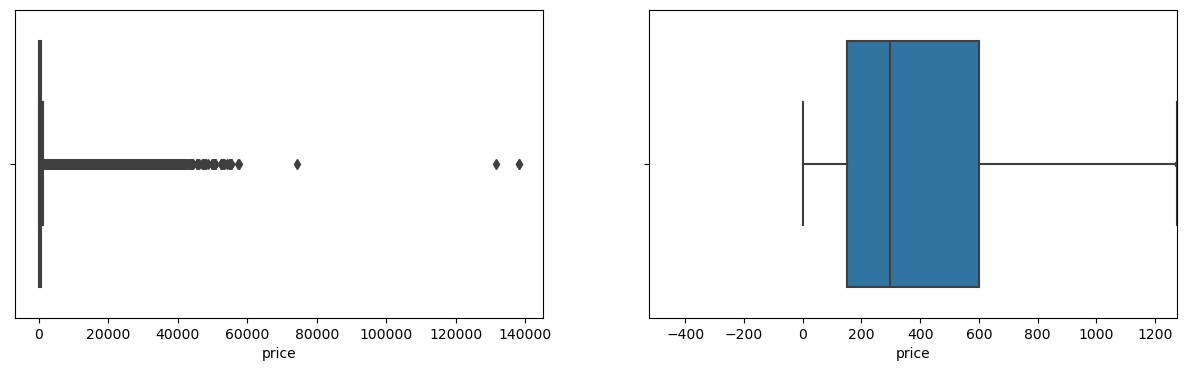

In [23]:
diagrama_caixa(base_airbnb['price'])

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



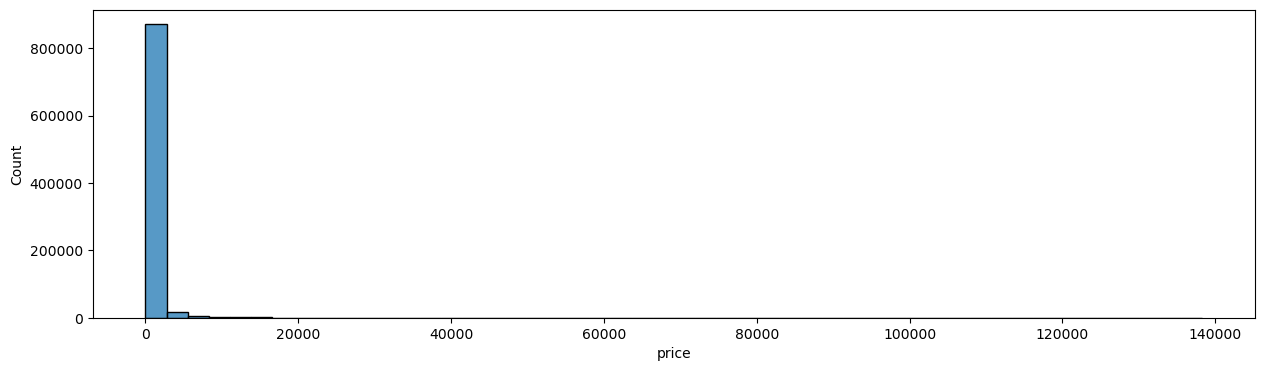

In [24]:
histograma(base_airbnb['price'])

**Decisão sobre tratamento de dados:**
- Excluir os outliers, pois como o foco do modelo que será criado é prever a diária de um imóvel comun, posso supor que os imóveis acima do limite superior são apenas de apartamentos de altíssimo luxo, que não é nosso objetivo principal

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print("A quantidade de linhas removidas foi de: {}".format(linhas_removidas))

A quantidade de linhas removidas foi de: 87282


In [26]:
base_airbnb.shape[0]

810427

**Repetindo os gráficos de histograma para verificar a distribuição dos dados sem os outliers**

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



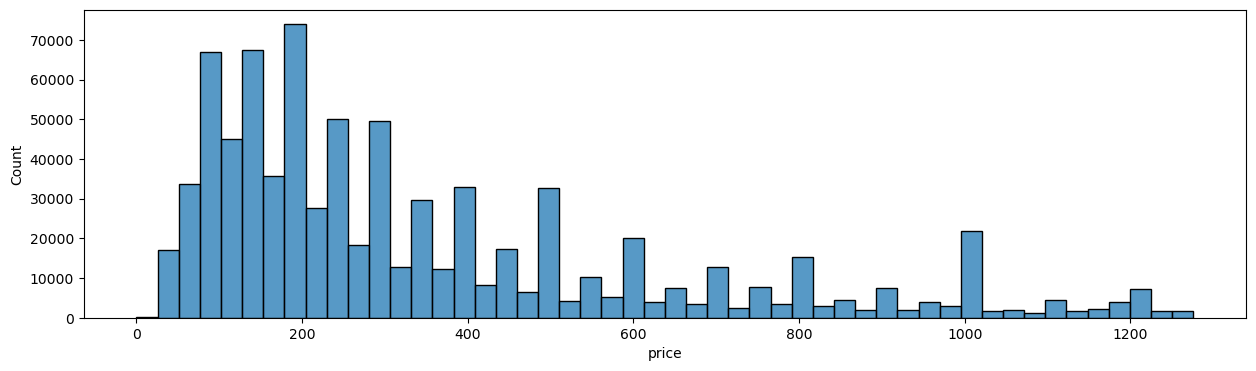

In [27]:
histograma(base_airbnb['price'])

#### ii) ANÁLISE EXPLORATÓRIA - COLUNA EXTRA_PEOPLE

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



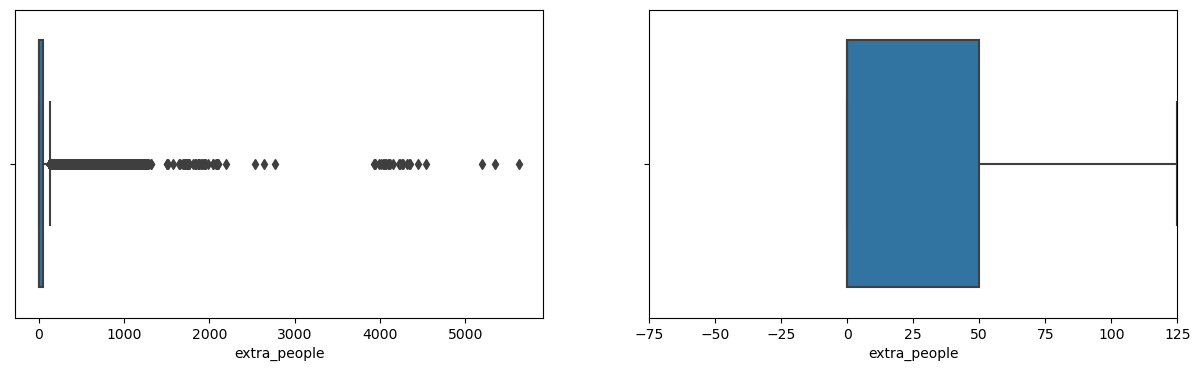

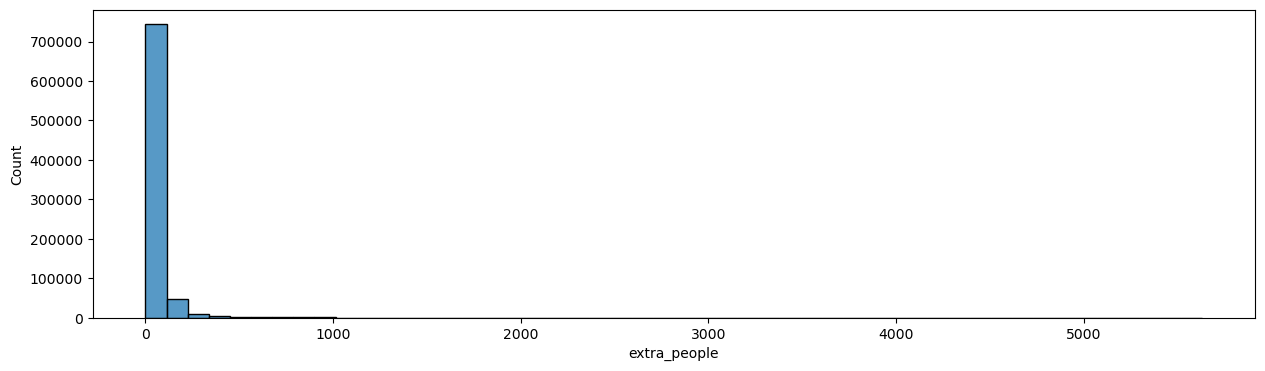

In [28]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

**Decisão sobre tratamento de dados:**
- Excluir os outliers
- Manter a feature / coluna, pois deve ser importante para o resultado do preço da diária do imóvel

A quantidade de linhas removidas foi de: 59194


c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



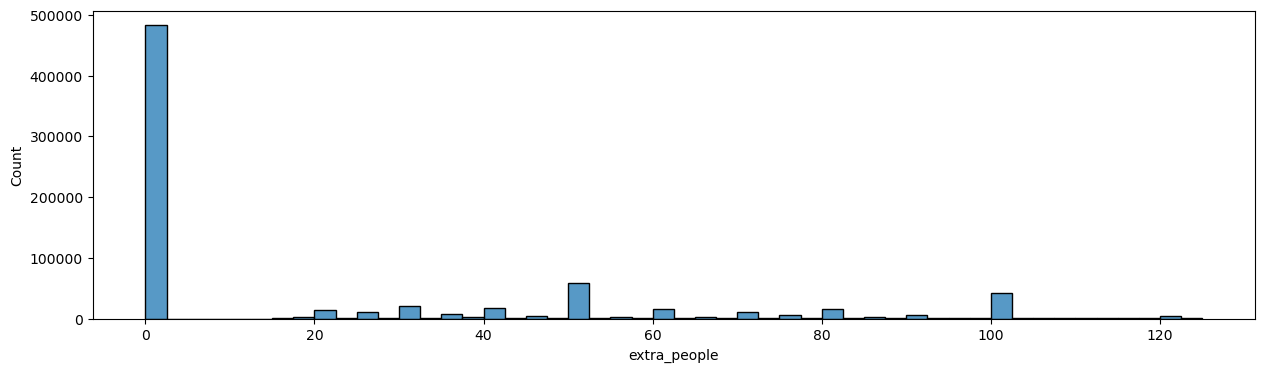

In [29]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print("A quantidade de linhas removidas foi de: {}".format(linhas_removidas))

histograma(base_airbnb['extra_people'])

### **b) COLUNAS COM VALORES NUMÉRICOS DISCRETOS**

##### Separando apenas as colunas do dataframe com dados numéricos discretos:
- host_listings_count         
- accommodates                  
- bathrooms                   
- bedrooms                    
- beds                        
- guests_included               
- minimum_nights                
- maximum_nights                
- number_of_reviews             

*OBS: Para esses dados discretos, como a maior parte dos números são números inteiros e há menor variação do que os valores do preço, não faz muito sentido fazer um gráfico histograma. Nessa caso, seria melhor gerarmos gráficos de barras*

#### i) ANÁLISE EXPLORATÓRIA - host_listings_count   

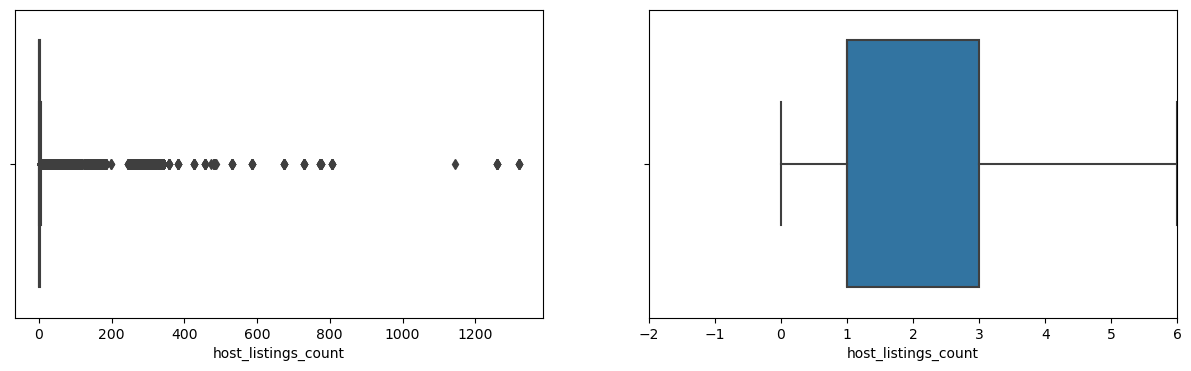

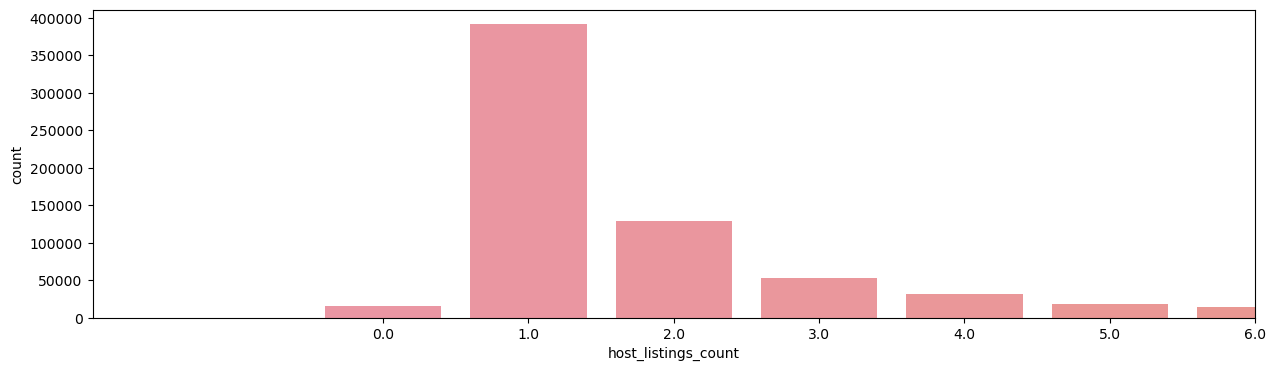

In [30]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

**Decisão sobre tratamento de dados:**
- Excluir os outliers, porque dificilmente uma pessoa comum terá mais do que 6 imóveis, a menos que seja uma imobiliária ou alguém que tem vários imóveis para locação, o que não é o público alvo do projeto

In [31]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print("A quantidade de linhas removidas foi de: {}".format(linhas_removidas))

A quantidade de linhas removidas foi de: 97723


#### ii) ANÁLISE EXPLORATÓRIA - COLUNA accommodates

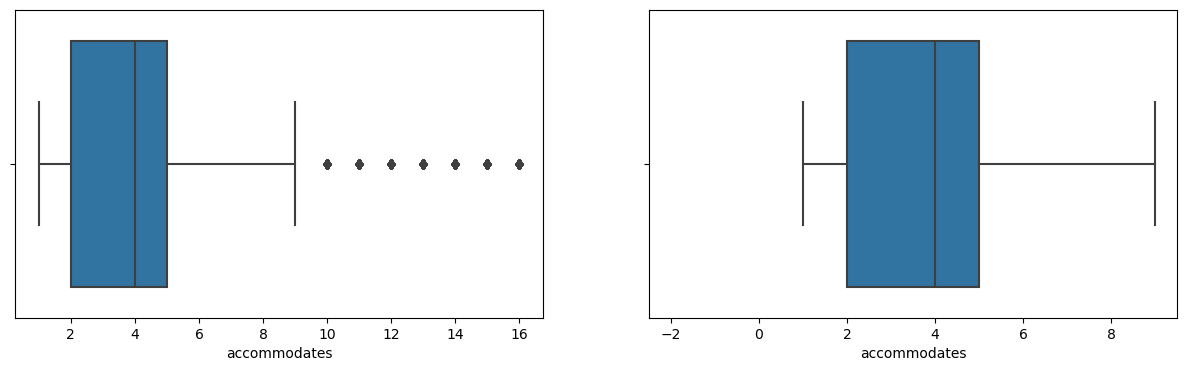

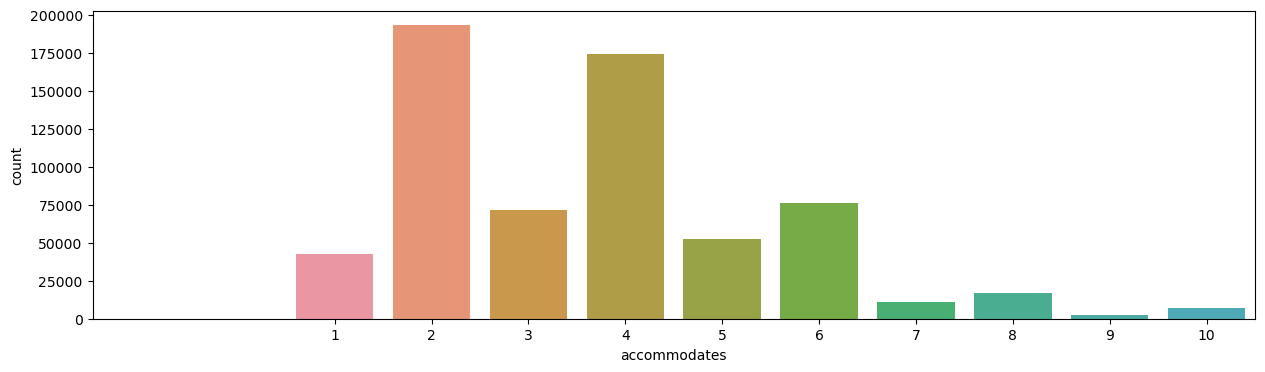

In [32]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

**Decisão sobre tratamento de dados:**
- Excluir os outliers

A quantidade de linhas removidas foi de: 13146


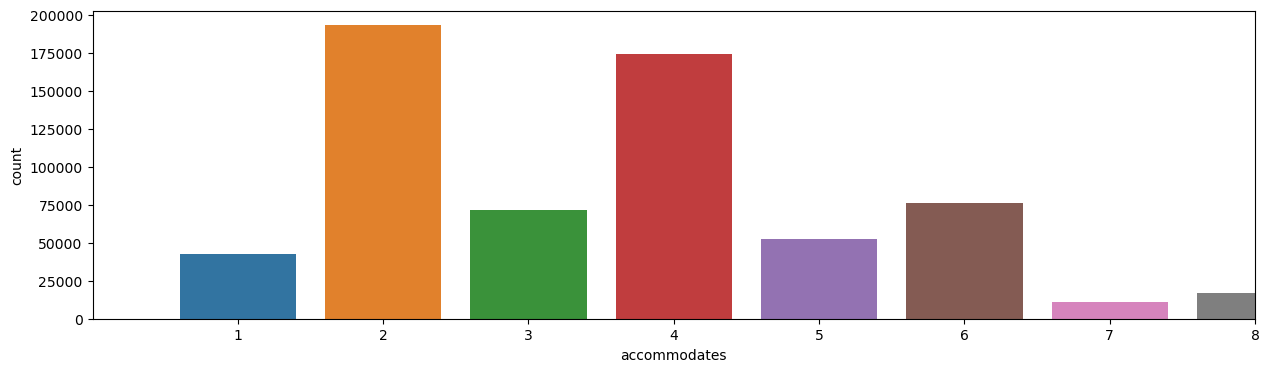

In [33]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print("A quantidade de linhas removidas foi de: {}".format(linhas_removidas))

grafico_barra(base_airbnb['accommodates'])

#### iii) ANÁLISE EXPLORATÓRIA - COLUNA bathrooms

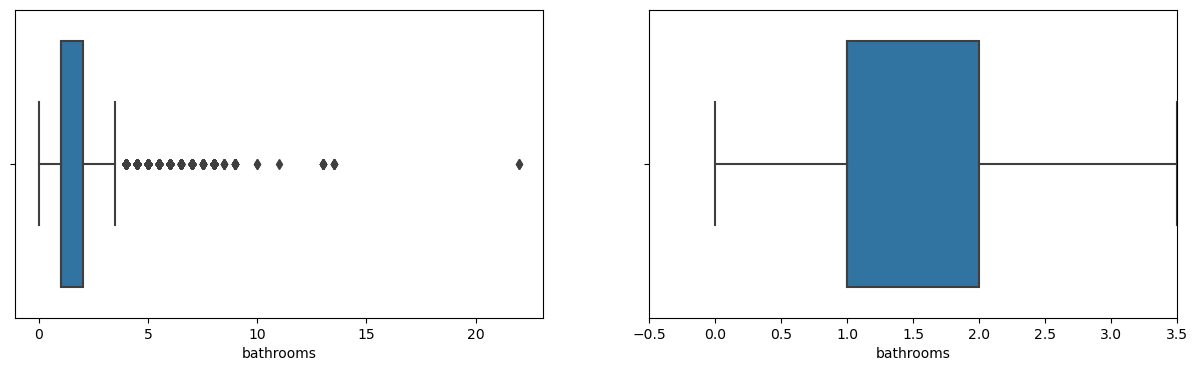

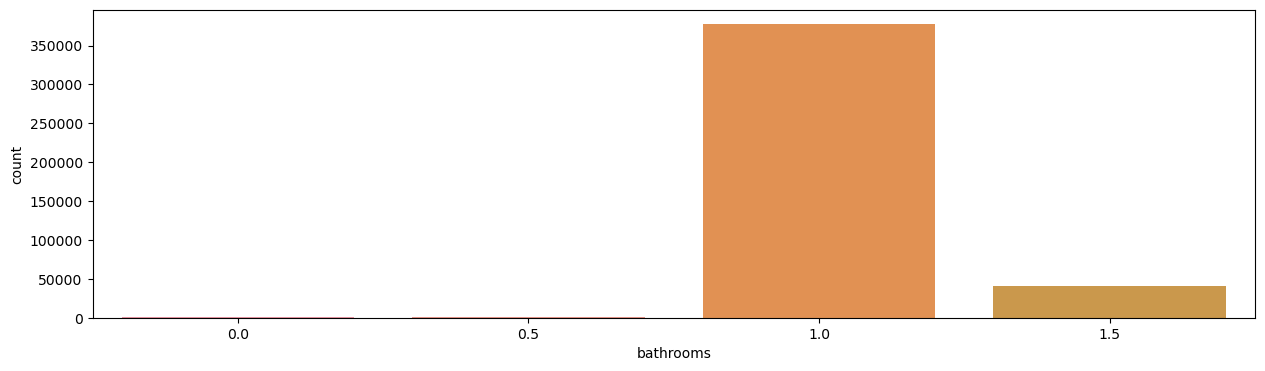

In [34]:
diagrama_caixa(base_airbnb['bathrooms'])
grafico_barra(base_airbnb['bathrooms'])

<Axes: xlabel='bathrooms', ylabel='count'>

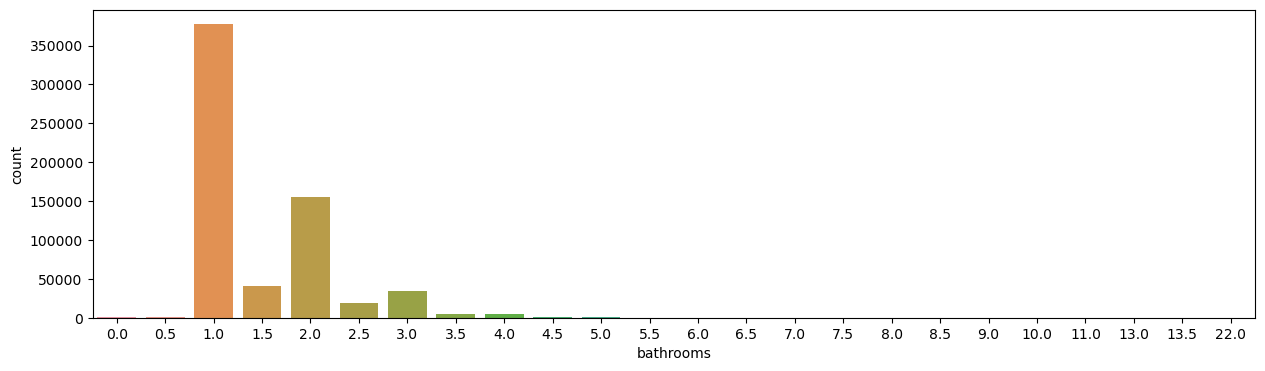

In [35]:
# O gráfico de barras acima não ficou adequado para a análise, pois definindo os limites do eixo X de acordo com os outliers não conseguimos avaliar toda dispersão dos dados
# Repetindo o mesmo tipo de gráfico sem limitar o eixo X conforme os outliers
plt.figure(figsize=(15,4))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

**Decisão sobre tratamento de dados:**
- Excluir os outliers, uma vez que os dados variam muito e acredito que uma grande quantidade de banheiros não deve inflenciar significativamente no valor da diária

In [36]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print("A quantidade de linhas removidas foi de: {}".format(linhas_removidas))

A quantidade de linhas removidas foi de: 6894


#### iv) ANÁLISE EXPLORATÓRIA - COLUNA bedrooms

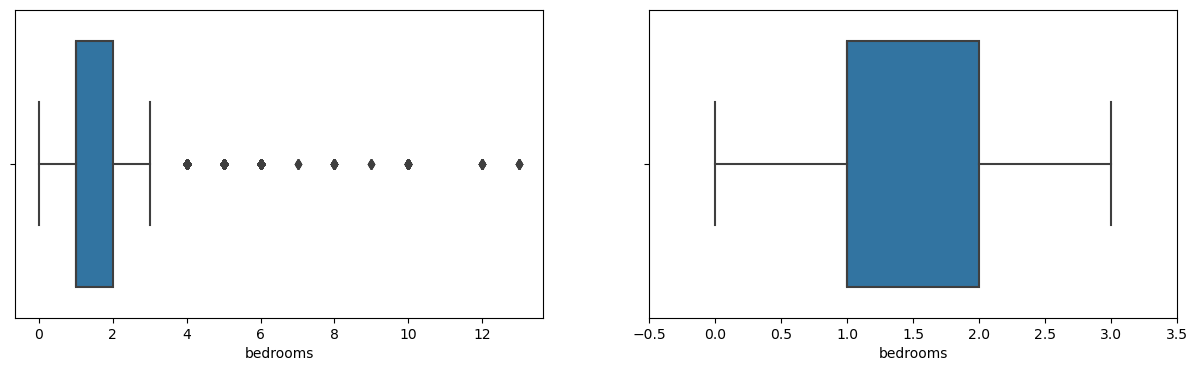

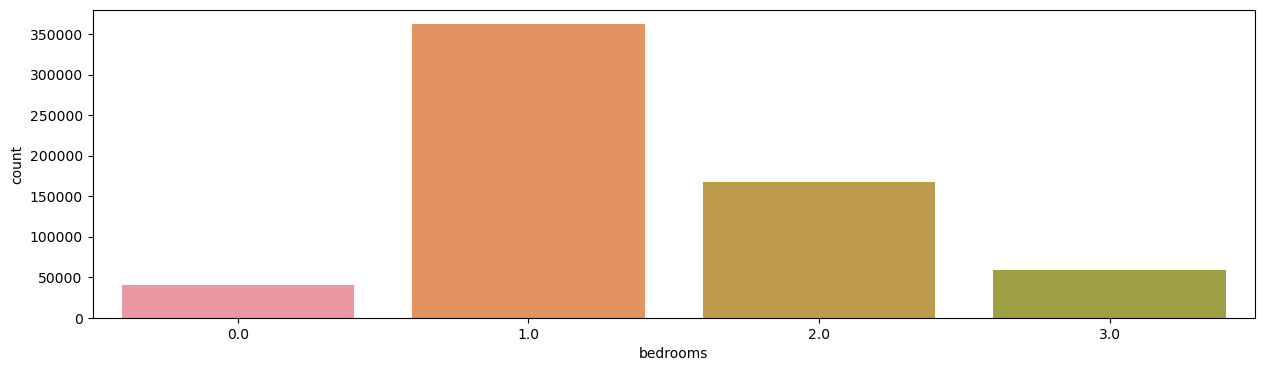

In [37]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

**Decisão sobre tratamento de dados:**
- Excluir os outliers

In [38]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print("A quantidade de linhas removidas foi de: {}".format(linhas_removidas))

A quantidade de linhas removidas foi de: 5482


#### v) ANÁLISE EXPLORATÓRIA - COLUNA beds

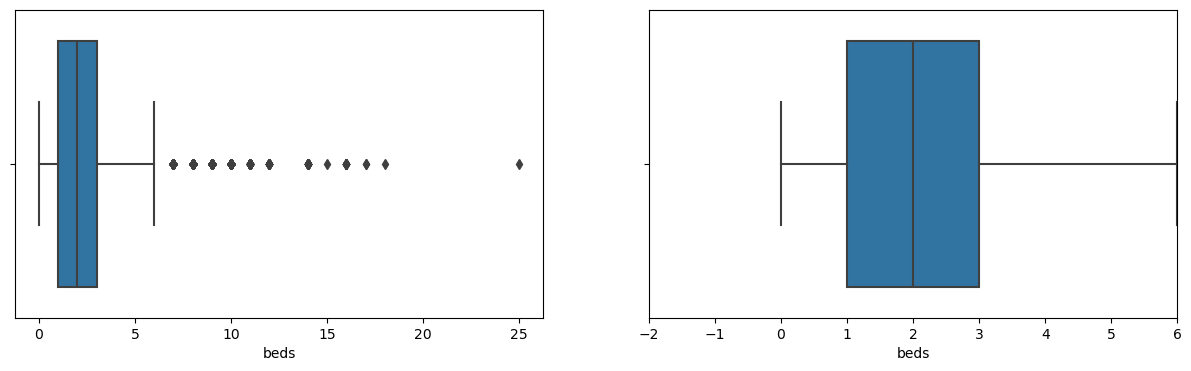

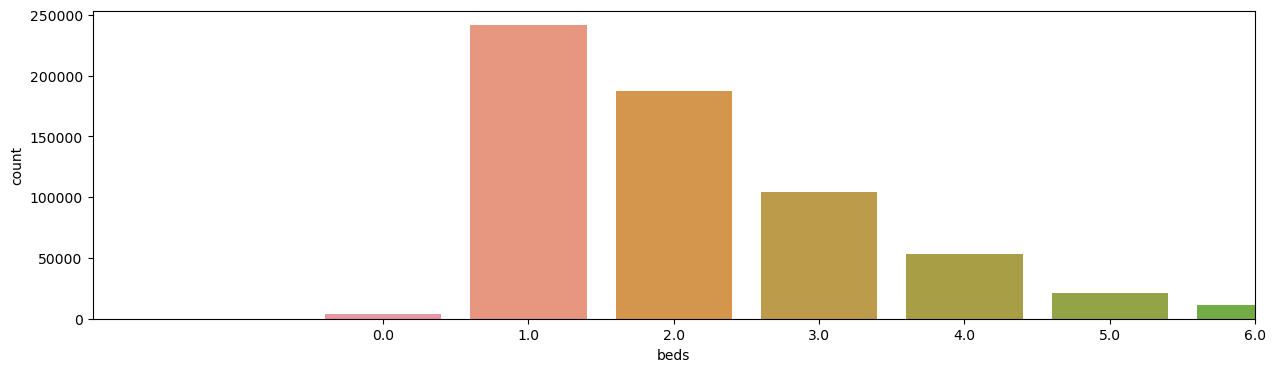

In [39]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

**Decisão sobre tratamento de dados:**
- Excluir os outliers, pois o valor da diária do imóvel não deve crescer na mesma proporção do número de quartos

In [40]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print("A quantidade de linhas removidas foi de: {}".format(linhas_removidas))

A quantidade de linhas removidas foi de: 5622


#### vi) ANÁLISE EXPLORATÓRIA - COLUNA guests_included

C:\Users\brcprrcchave\AppData\Local\Temp\ipykernel_20256\2093254549.py:7: UserWarning:

Attempting to set identical low and high xlims makes transformation singular; automatically expanding.



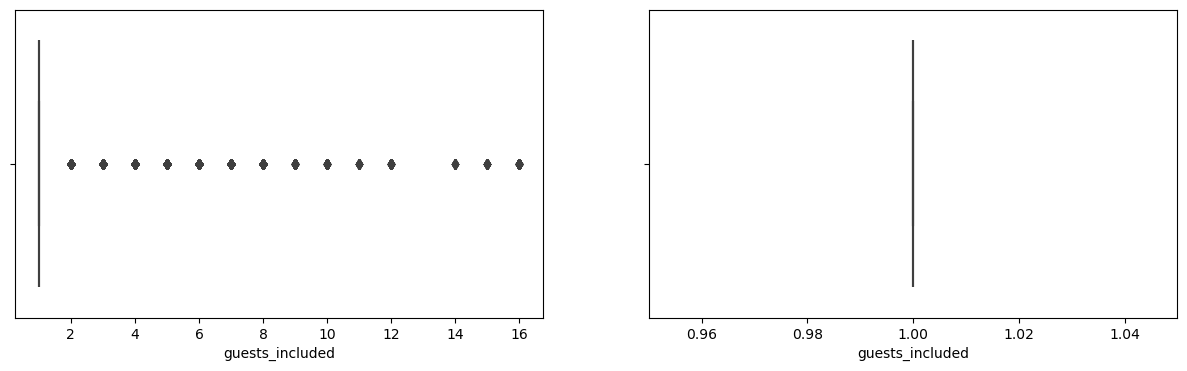

In [41]:
diagrama_caixa(base_airbnb['guests_included'])

<Axes: xlabel='guests_included', ylabel='count'>

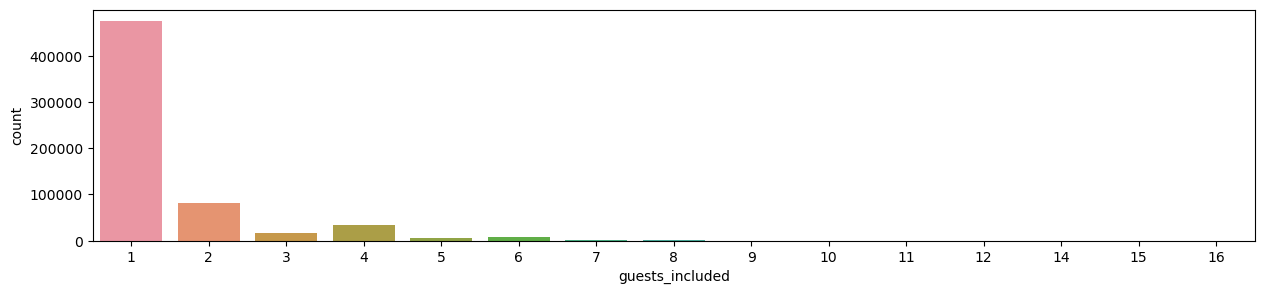

In [42]:
# Repetindo o gráfico de barras sem limitar os dados do eixo X de acordo com os limites de outliers
plt.figure(figsize=(15,3))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

In [43]:
print(limites(base_airbnb['guests_included']))

(1.0, 1.0)


**Decisão sobre tratamento de dados:**
- Será excluído essa feature do projeto, pois os limites inferiores e superiores dos outliers é 1, temos 500 mil dados com guest_included igual a 1. 
- Não faz sentido metade dos imóveis do airbnb ser pra uma pessoa só. Parece ser um erro de preenchimento dos dados do imóvel de quem disponibiliza seu imóvel na plataforma, e o valor padrão que o airbnb deve assumir é 1

In [44]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

#### vii) ANÁLISE EXPLORATÓRIA - COLUNA minimum_nights

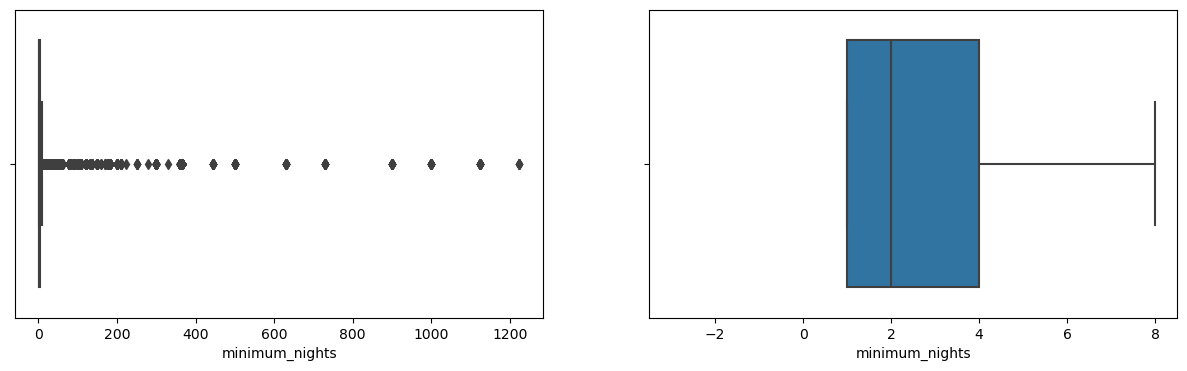

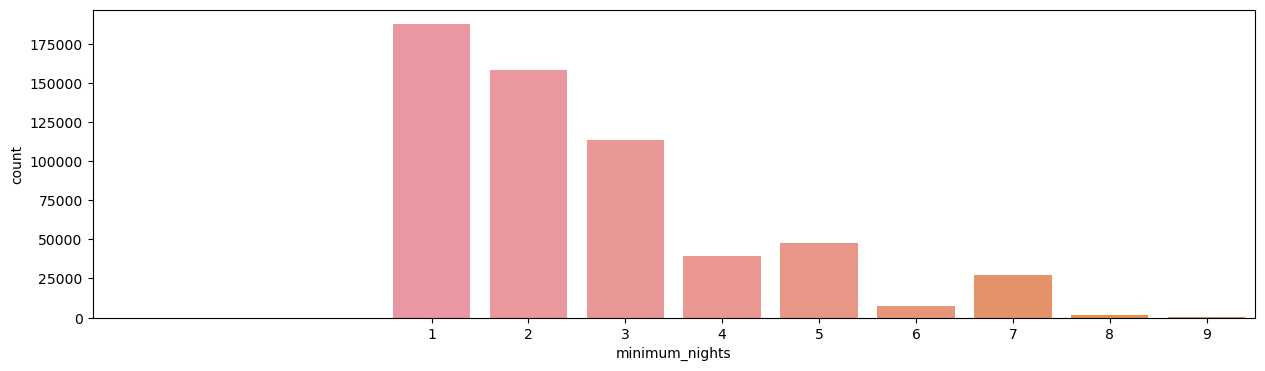

In [45]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

**Decisão sobre tratamento de dados:**
- Excluir os outliers, pois existem imóveis com número mínimo de noites para locação muito grandes, que devem estar na plataforma do airbnb para contratos mais longos de locação, cujo preço médio por dia deve ser bem inferior aqueles para locações esporádicas, que é o objetivo principal deste projeto. 

In [46]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print("A quantidade de linhas removidas foi de: {}".format(linhas_removidas))

A quantidade de linhas removidas foi de: 40383


#### viii) ANÁLISE EXPLORATÓRIA - COLUNA maximum_nights

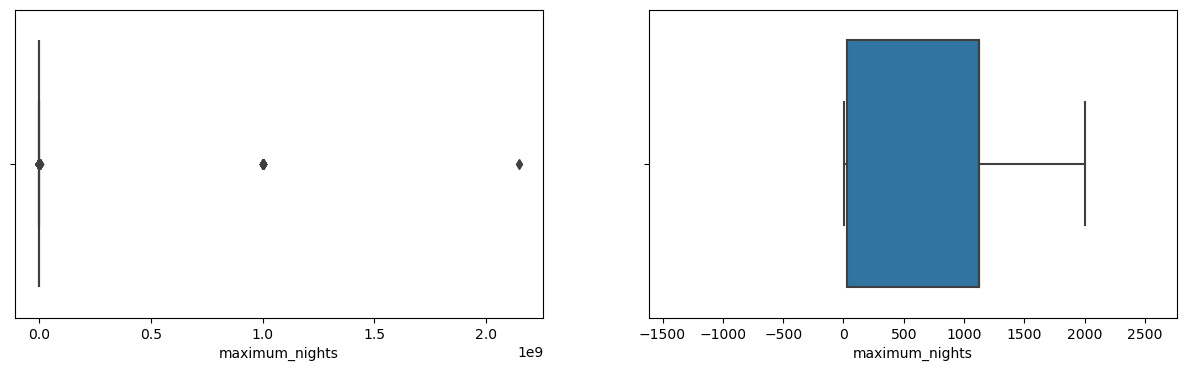

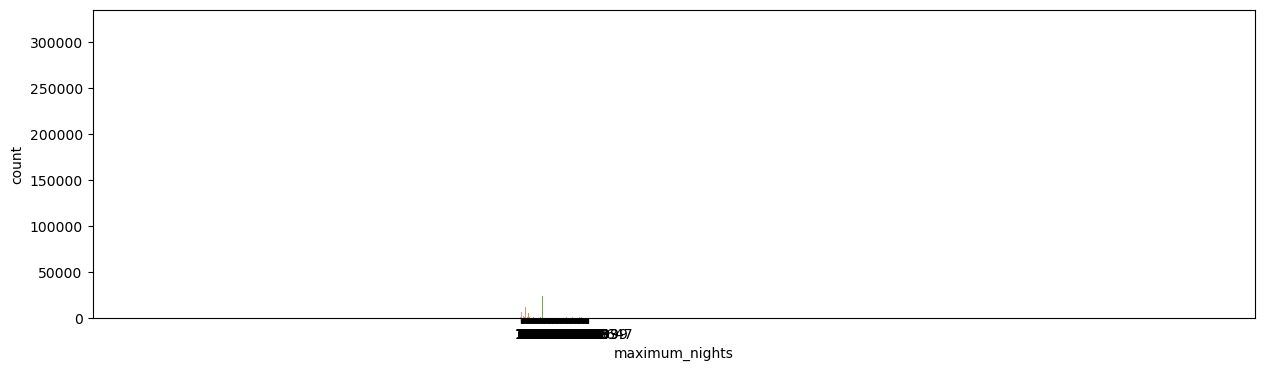

In [47]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

**Decisão sobre tratamento de dados:**
- Será excluído essa feature do projeto
- Não faz sentido a maior parte dos dados de maximum_nights ser igual a 0. Parece ser um erro de preenchimento dos dados do imóvel de quem disponibiliza seu imóvel na plataforma, e o valor padrão que o airbnb deve assumir é 0.

In [48]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

#### ix) ANÁLISE EXPLORATÓRIA - COLUNA number_of_reviews --> não pode excluir os outliers só, definido escolher coluna

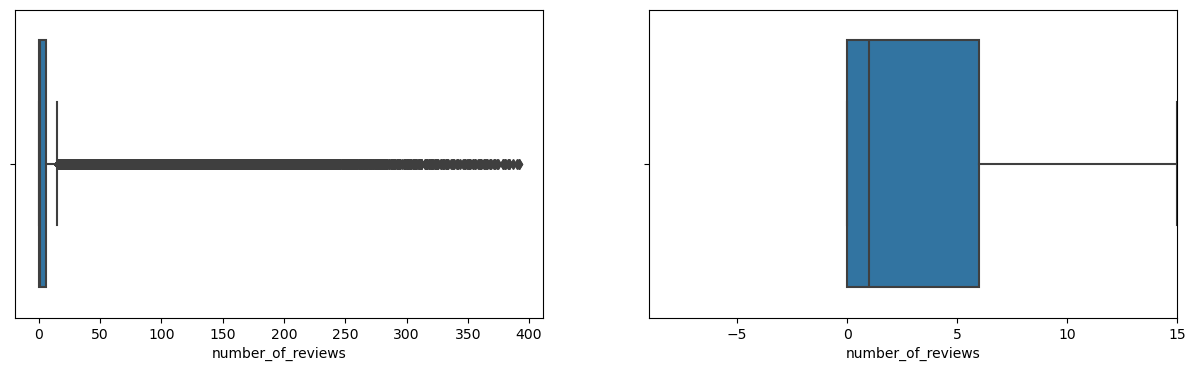

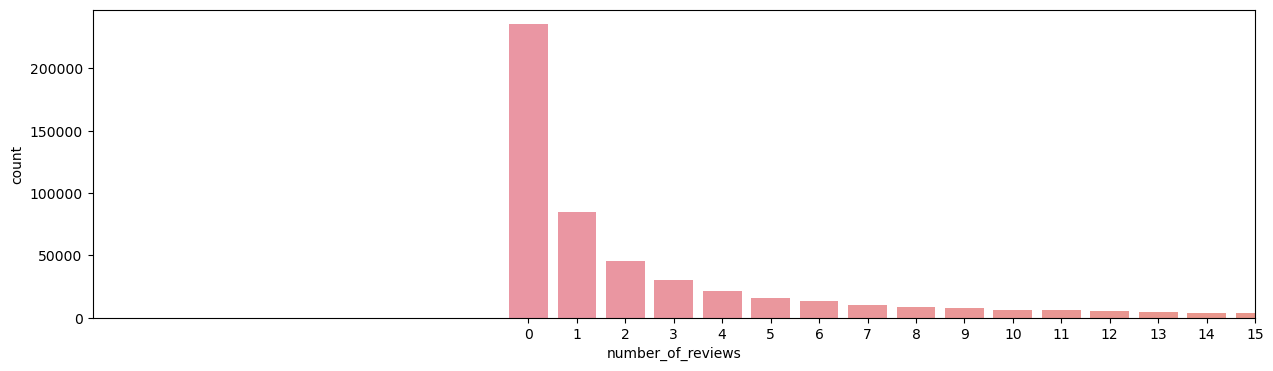

In [49]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

**Decisão sobre tratamento de dados:**
- Os outliers não podem ser excluídos
- Veja que o limite superior dos outliers para essa coluna é algo em torno de 6 reviews, mas os melhores host são aqueles que tem maior quantidade de reviews. 
Devido a essa "experiência" provavelmente são os imóveis cujo preço estão melhores definidos na plataforma, então se excluir somente os outliers dessa coluna estarei excluindo dados muito importantes para o projeto que estamos fazendo
- Para facilitar análise decidiremos excluir essa coluna do dataframe momentaneamente. Posteriormente, podemos transformar essa coluna numérica em categórica, definindo uma categoria para todos os reviews acima de determinado valor (acima de 10 reviews, por exemplo)

In [50]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### **c) TRATAMENTO DE COLUNAS "TEXTO"**

#### Esses tipos de coluna podem ser:

- Pode ser verdadeiro ou falso
- Textos padrões
- Listas de textos

property_type                                                       Apartment
room_type                                                     Entire home/apt
bed_type                                                             Real Bed
amenities                   {TV,Internet,"Air conditioning",Kitchen,Doorma...
cancellation_policy                               strict_14_with_grace_period

#### i) ANÁLISE EXPLORATÓRIA - COLUNA property_type

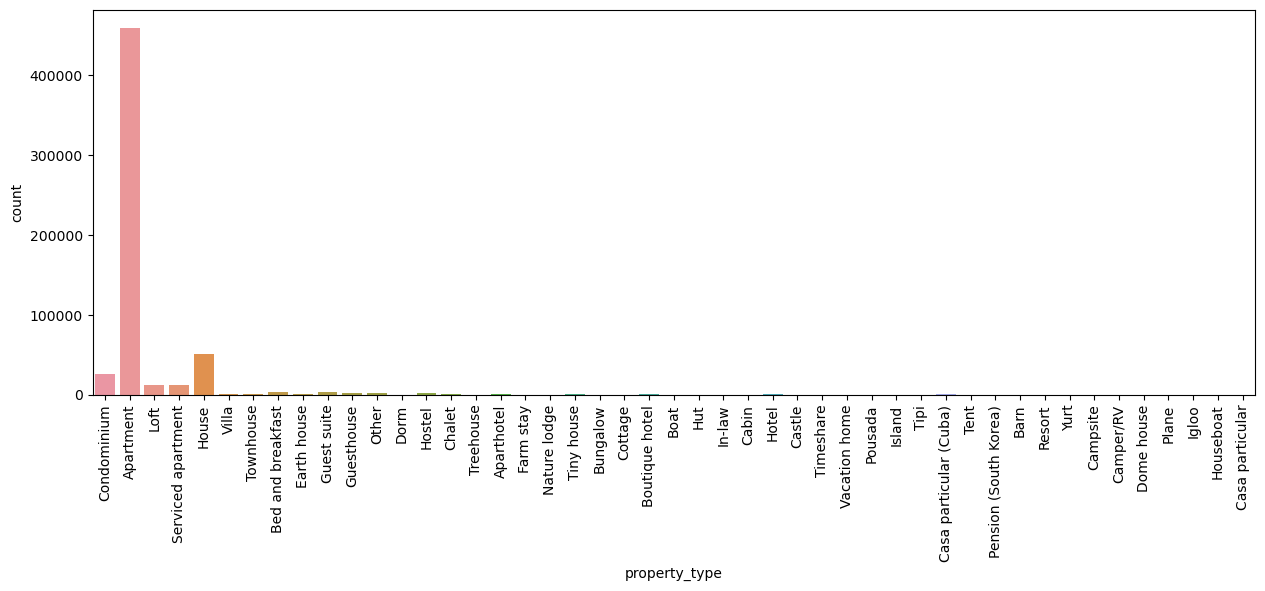

In [51]:
plt.figure(figsize=(15,5))
grafico = sns.countplot(x='property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

In [52]:
base_airbnb['property_type'].value_counts()

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

**Decisão sobre tratamento de dados:**
- Mudar todos os tipos de residência com menos de 2000 imóveis para a categoria "Outros"

In [53]:
tabela_tipo_imovel = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo_imovel in tabela_tipo_imovel.index:
    if tabela_tipo_imovel[tipo_imovel] < 2000:
        colunas_agrupar.append(tipo_imovel) 
print(colunas_agrupar)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']


In [54]:
for tipo_imovel in colunas_agrupar:
    linhas = base_airbnb['property_type'] == tipo_imovel
    colunas = 'property_type'
    base_airbnb.loc[linhas, colunas] = 'Outros'     

base_airbnb['property_type'].value_counts()

property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64

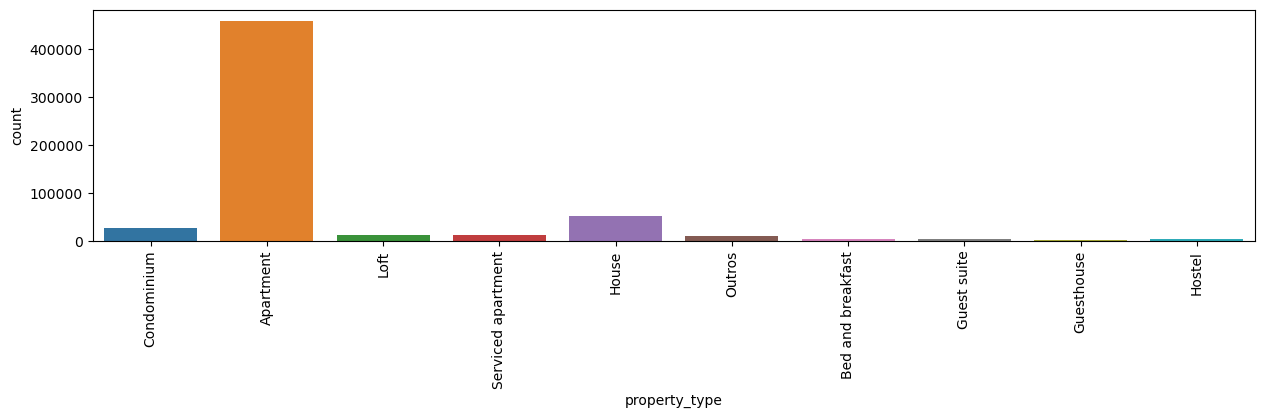

In [55]:
plt.figure(figsize=(15,3))
grafico = sns.countplot(x='property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

#### ii) ANÁLISE EXPLORATÓRIA - COLUNA room_type

In [56]:
base_airbnb['room_type'].value_counts()

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64

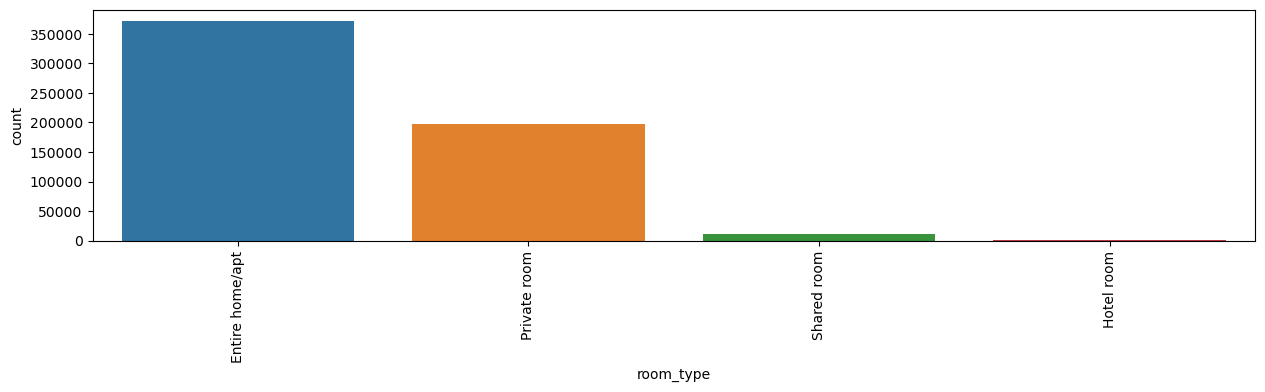

In [57]:
plt.figure(figsize=(15,3))
grafico = sns.countplot(x='room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

**Decisão sobre tratamento de dados:**
- Nenhum, pois temos apenas 4 categorias para esa feature

#### iii) ANÁLISE EXPLORATÓRIA - COLUNA bed_type

In [58]:
base_airbnb['bed_type'].value_counts()

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64

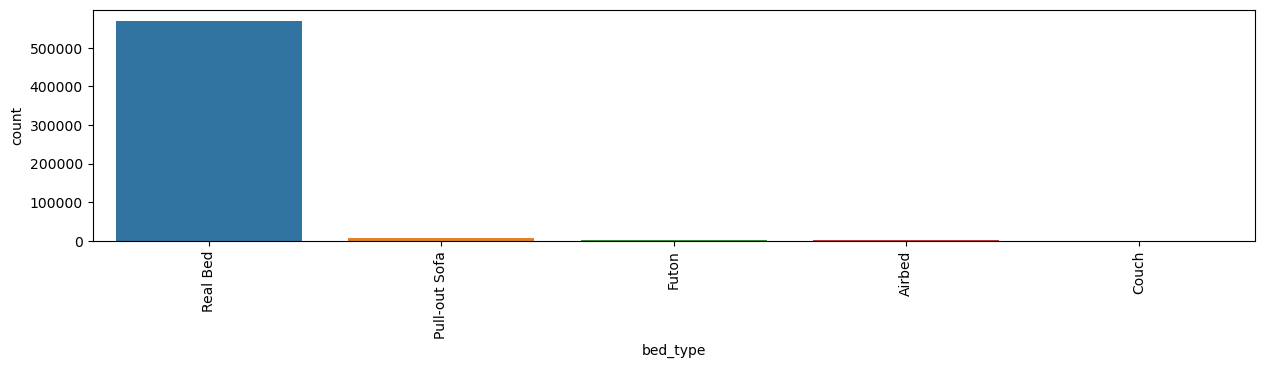

In [59]:
plt.figure(figsize=(15,3))
grafico = sns.countplot(x='bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

**Decisão sobre tratamento de dados:**
- Como a maior parte dos tipos de camar é "Real Bed" e também temos poucas categorias, irei agrupar os outros tipos de cama com o nome "outros" também.

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']


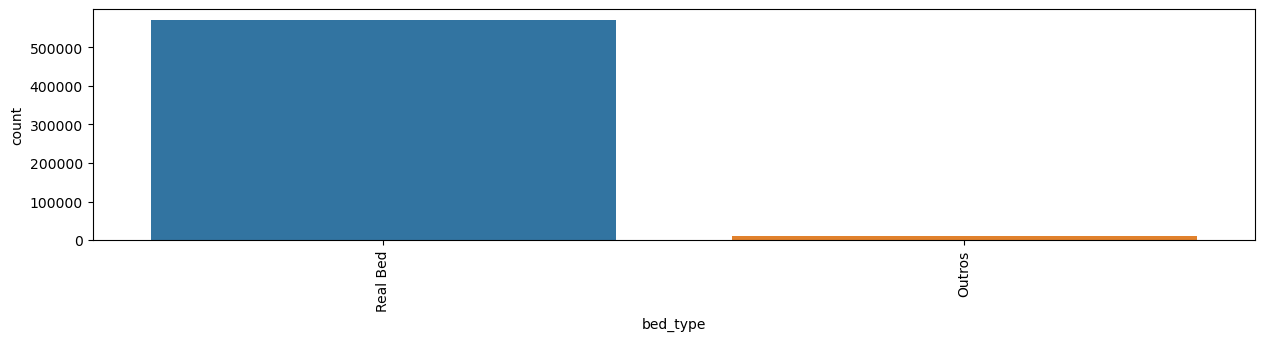

In [60]:
tabela_tipo_cama = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipo_cama.index:
    if tabela_tipo_cama[tipo] < 10000:
        colunas_agrupar.append(tipo) 
print(colunas_agrupar)

for tipo in colunas_agrupar:
    linhas = base_airbnb['bed_type'] == tipo
    colunas = 'bed_type'
    base_airbnb.loc[linhas, colunas] = 'Outros'     

plt.figure(figsize=(15,3))
grafico = sns.countplot(x='bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

#### iv) ANÁLISE EXPLORATÓRIA - COLUNA cancellation_policy

In [61]:
base_airbnb['cancellation_policy'].value_counts()

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64

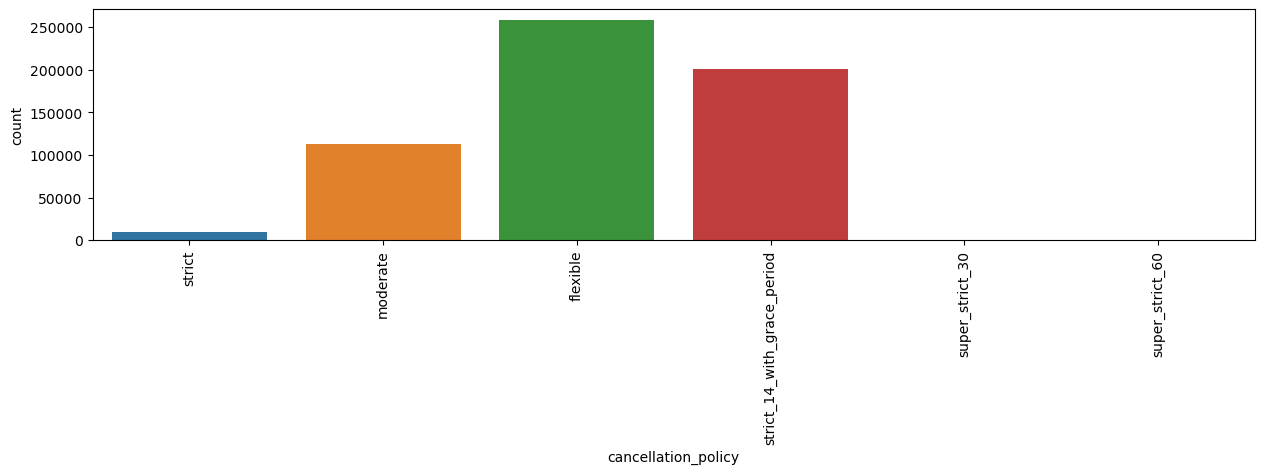

In [62]:
plt.figure(figsize=(15,3))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

**Decisão sobre tratamento de dados:**
- Agrupar todas as categorias "strict", "super_strict_30" e "super_strict_60" numa só, chamada "strict*"

['strict', 'super_strict_60', 'super_strict_30']


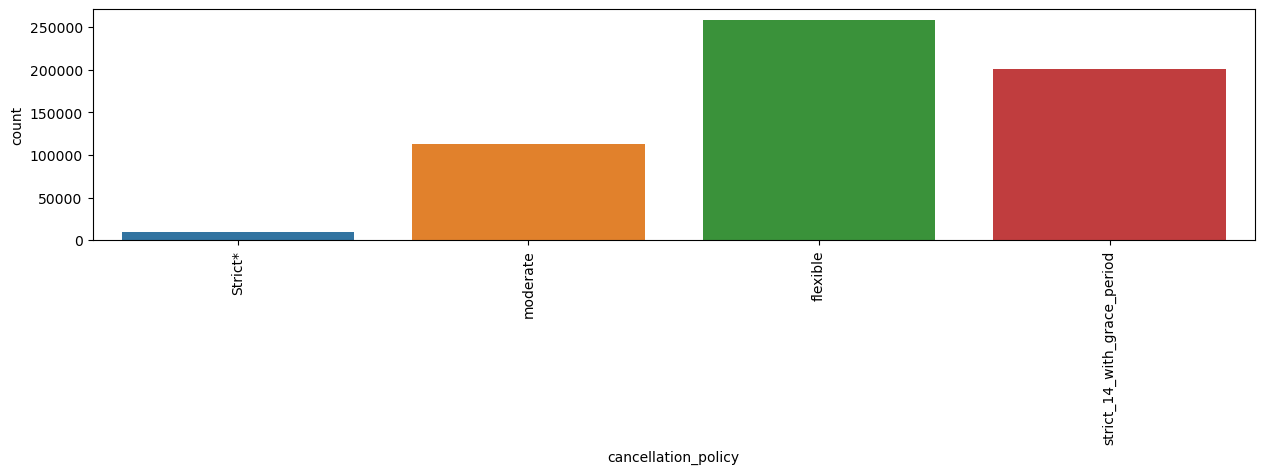

In [63]:
tabela_politica_cancel = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_politica_cancel.index:
    if tabela_politica_cancel[tipo] < 10000:
        colunas_agrupar.append(tipo) 
print(colunas_agrupar)

for tipo in colunas_agrupar:
    linhas = base_airbnb['cancellation_policy'] == tipo
    colunas = 'cancellation_policy'
    base_airbnb.loc[linhas, colunas] = 'Strict*'     

plt.figure(figsize=(15,3))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)


#### v) ANÁLISE EXPLORATÓRIA - COLUNA amenities

In [64]:
base_airbnb['amenities'].iloc[0]

'{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Paid parking off premises","Smoking allowed",Doorman,Elevator,"Hot tub","Family/kid friendly","Suitable for events",Essentials,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in","Front desk/doorperson","Private entrance","Hot water","Bed linens","Luggage dropoff allowed"}'

**Observações a respeito dos diferentes valores de ammenities**
- As "ammenities" variam bastante de um imóvel para outro, e algumas até tem descrições padrões mas muitas são descritas especificamente por 1 usuário.
- Alguns hosts costumam detalhar várias "comodidades" e outros bem poucos. Talvez aqueles que detalham melhor suas comodidades são mais atenciosos, detalhistas, e possuem um imóvel que oferece mais recursos ao cliente
- Portanto, podemos analisar as "ammenities" nosso projeto pela quantidade de comodidades que cada imóvel possui

**Decisão sobre tratamento de dados:**
- Criar um coluna que calcula a quantidade de comodidades com base na coluna ammenities
- Excluir a coluna ammenities da análise

In [65]:
print(base_airbnb['amenities'].iloc[0].split(','))       
# Temos que separar o texto com esse split(',') pois se fossemos aplicar o len() sem esse comando seria contado o número de letras e não o número de comodidades

print("Qtade de comodidades: {}".format(len(base_airbnb['amenities'].iloc[0].split(','))))

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
Qtade de comodidades: 25


In [66]:
# Criando a coluna com a quantidade de comodidades de cada imóvel
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

In [67]:
# Excluindo a coluna 'amenities' do dataframe
base_airbnb = base_airbnb.drop('amenities', axis=1)

##### Tratando a coluna n_amenities como as outras colunas numéricas

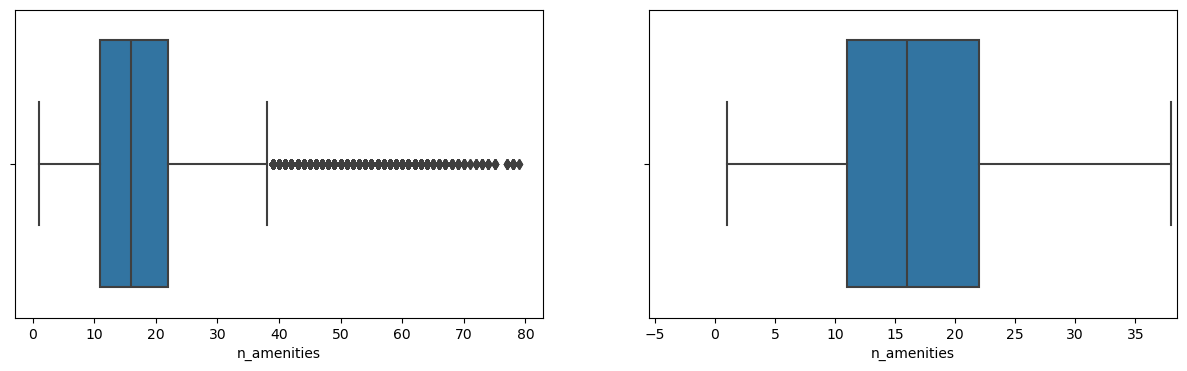

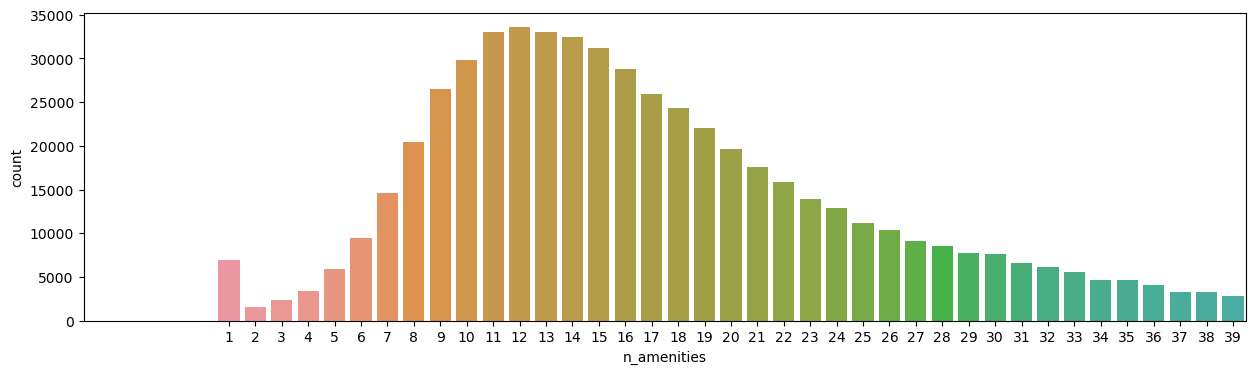

In [68]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

**Nova decisão sobre tratamento de dados:**
- Excluir os outliers, porque a partir de um determinado valor de comodidades (talvez o limite superior dos outliers) não deve alterar no preço do imóvel ter 30 ou 40 comodidades.

In [69]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print("A quantidade de linhas removidas foi de: {}".format(linhas_removidas))

A quantidade de linhas removidas foi de: 24343


### **d) COLUNAS COM VARIÁVEIS GEOGRÁFICAS**

#### VISUALIZAÇÃO DE MAPA DE DENSIDADE PARA ANÁLISE DA LONGITUDE E LATITUDE

Pelo gráfico abaixo vamos poder ver que a localização do imóvel poderá ser bem significativa na determinação do preço do imóvel, pois os imóveis da zona zul do RJ (Ipanema, Leblon) e os da Barra da Tijuca aparecem com a coloração amarela no gráfico, indicando um maior preço

In [70]:
import plotly.express as px

amostra = base_airbnb.sample(50000)        
# Limitando o número de dados plotados pois usando todos os dados pode demorar tempo demais pra gerar o gráfico

centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price',
                       radius=2.5, center=centro_mapa, zoom=10,
                       mapbox_style='open-street-map',
                       width=1200, height=600)     

mapa.show()

## 5) Encoding

Ajustando as features categóricas para uso no modelo de machine learning. Critérios:
- A) Features de variavéis True ou False, vamos substituir True por 1 e False por 0
- B) Features com variáveis categóricas que contém textos usarei o método de encoding de variáveis dummies

In [71]:
base_airbnb.head(1)

host_is_superhost  host_listings_count   latitude  longitude property_type  \
1                 t                  2.0 -22.965919 -43.178962   Condominium   

         room_type  accommodates  bathrooms  bedrooms  beds  bed_type  price  \
1  Entire home/apt             5        1.0       2.0   2.0  Real Bed  270.0   

   extra_people  minimum_nights instant_bookable is_business_travel_ready  \
1          51.0               4                t                        f   

  cancellation_policy   ano  mes  n_amenities  
1             Strict*  2018    4           25

In [72]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready' ]
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

#### A) Encoding de variáveis Verdadeiro / Falso

In [73]:
base_airbnb_codificado = base_airbnb.copy()          # Definido um segundo dataframe para fazer o processo de encoding.

for coluna_tratada in colunas_tf:
    base_airbnb_codificado.loc[base_airbnb_codificado[coluna_tratada]=='t', coluna_tratada] = 1
    base_airbnb_codificado.loc[base_airbnb_codificado[coluna_tratada]=='f', coluna_tratada] = 0

print(base_airbnb_codificado.iloc[0])


host_is_superhost                         1
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
extra_people                           51.0
minimum_nights                            4
instant_bookable                          1
is_business_travel_ready                  0
cancellation_policy                 Strict*
ano                                    2018
mes                                       4
n_amenities                              25
Name: 1, dtype: object


#### B) Encoding de variáveis Categóricas (texto)

In [74]:
# colunas_categorias = ['property_type', 'property_type', 'bed_type', 'cancellation_policy']        relembrando apenas quais colunas sofrerão esse processo de encoding

base_airbnb_codificado = pd.get_dummies(data=base_airbnb_codificado, columns=colunas_categorias, dtype=int)

base_airbnb_codificado.head()

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_Strict*  cancellation_policy_flexible  \
1                            1                             0   
3                            1                             0   
4                            1                             0   
5                            1                             0   
6                            1                             0   

   cancellation_policy_moderate  \
1                             0   
3                             0   
4                             0   
5                             0   
6                             0   

   cancellation_policy_strict_14_with_grace_period  
1                                                0  
3                                                0  
4                                                0  
5                                                0  
6                                                0  

[5 rows x 36 columns]

## 6) Modelo de Previsão de Resultados

### Passos para Criar / Treinar um Modelo
- Passo 1) Definir se é um modelo de classificação ou regressão **-->** Nesse caso, regressão.
- Passo 2) Escolher as métricas de avaliação do modelo **-->** Será usado os métricas de R² e RMSE - Raiz do erro quadrático médio, além de avaliar o tempo de execução de cada modelo
- Passo 3) Escolher quais modelos vamos usar / testar **-->** Será usados os modelos Linear Regression, Random Forest Regressor e Extra Trees
- Passo 4) Treinar os modelos e testar
- Passo 5) Comparar os resultados dos modelos e escolher o modelo vencedor
- Passo 6) Analisar o melhor modelo mais a fundo
- Passo 7) Fazer ajustes no melhor modelo

#### Passo 2) Metricas de avaliação

In [75]:
from sklearn.metrics import r2_score, mean_squared_error

In [76]:
# Criando uma função para análise de cada modelo com base nas métricas R² e RMSE

def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f"Modelo {nome_modelo}: \nR2: {r2:.2%} \nRSME: {RSME:.2f}"

#### Passo 3) Escolhendo quais modelos vamos usar
- Linear Regression
- Random Forest Regressor
- Extra Trees Regressor

- Escolha dos modelos a serem testados

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor            # Modelos de arvore de decisão vem da biblioteca sklearn.ensemble

modelos = {'LinearRegression': LinearRegression(),
           'RandomForest': RandomForestRegressor(),
           'ExtraTrees': ExtraTreesRegressor()}

#modelos = {'ExtraTrees': ExtraTreesRegressor()}

#### Passo 4) Treinando e testando os modelos

- Separação das variáveis

In [78]:
y = base_airbnb_codificado['price']
X = base_airbnb_codificado.drop('price', axis=1)

- Separação dos dados em treino e teste 

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

- Treino do modelo

In [80]:
for item in modelos.items():
    print(item)

print("------------------------------------------------------------------------")

import time

for nome_modelo, modelo in modelos.items():
    start_time = time.time()
    
    modelo.fit(X_train, y_train)
    previsao = modelo.predict(X_test)
    
    end_time = time.time()
    
    # Avaliação de cada modelo
    print(avaliar_modelo(nome_modelo, y_test, previsao)) 
    print("Tempo de execução: {:.1f} segundos\n".format(end_time-start_time))


('LinearRegression', LinearRegression())
('RandomForest', RandomForestRegressor())
('ExtraTrees', ExtraTreesRegressor())
------------------------------------------------------------------------
Modelo LinearRegression: 
R2: 32.70% 
RSME: 217.54
Tempo de execução: 2.8 segundos

Modelo RandomForest: 
R2: 97.23% 
RSME: 44.11
Tempo de execução: 443.3 segundos

Modelo ExtraTrees: 
R2: 97.50% 
RSME: 41.91
Tempo de execução: 454.5 segundos



- Teste do modelo

In [81]:
for nome_modelo, modelo in modelos.items():
    start_time = time.time()
    previsao = modelo.predict(X_test)
    end_time = time.time()
    print(avaliar_modelo(nome_modelo, y_test, previsao))
    print("Tempo de execução: {:.1f} segundos\n".format(end_time-start_time))


Modelo LinearRegression: 
R2: 32.70% 
RSME: 217.54
Tempo de execução: 0.3 segundos

Modelo RandomForest: 
R2: 97.23% 
RSME: 44.11
Tempo de execução: 14.2 segundos

Modelo ExtraTrees: 
R2: 97.50% 
RSME: 41.91
Tempo de execução: 8.6 segundos



#### Passo 5) Comparar os resultados dos modelos e escolher o modelo vencedor

Conclusões:
- O melhor modelo foi o Extra Trees, pois apresenta o maior R2 e menor valor de RMSE.
- Os valores do R2 estõ bem próximos do Extra Trees e Random Forest
- O modelo de Regressão Linear foi o que apresentou os piores resultados, deve ser descartado
- Como os resultados dos modelos Extra Trees e Random Forest são similares, poderia escolher pelo tempo de execução. Nesse caso ainda assim o modelo de Extra Trees leva vantagem
- Portanto, o modelo vencedor é *ExtraTrees*


#### Passo 6) Análise do Melhor Modelo

Importante entender como esse modelo funciona? Quais features são importantes e quais devo excluir do modelo para torná-lo mais simples e rápido
- Depois do modelo pronto e escolhido o melhor modelo, analisamos como o melhor modeo funciona
- Identificamos a importância de cada feature para ver há oportunidades de melhoria (retirando features / colunas menos importantes, ou reduzindo quantidade de variavéis categóricas, por exemplo)

Feito alterações na nossa base de dados, para avaliar se o modelo ficou melhor ou pior, levar em consideração:
- Métricas de avaliação escolhidas (R2 ou RMSE)
- Velocidade do modelo (tempo de execução)
- Simplicidade do modelo (menos features)

In [82]:
# Analisando a importância de cada feature
print(modelos['ExtraTrees'].feature_importances_)

[0.0132835  0.04026838 0.10384352 0.10141963 0.07194922 0.07422466
 0.11496187 0.05285135 0.08701292 0.06502432 0.02186582 0.
 0.01127642 0.00471938 0.08916964 0.01279323 0.00130513 0.00519818
 0.00069158 0.00092947 0.00060307 0.00698705 0.00212138 0.00236771
 0.00226081 0.06118236 0.00030686 0.00445113 0.00193385 0.00272063
 0.00268796 0.00084337 0.01900696 0.0121357  0.00760295]


In [83]:
print(X_train.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'ano',
       'mes', 'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'bed_type_Outros',
       'bed_type_Real Bed', 'cancellation_policy_Strict*',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')


In [84]:
# Classificando as features / colunas com maior importância pro modelo

importancia_features = pd.DataFrame(modelos['ExtraTrees'].feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

0
bedrooms                                         0.114962
latitude                                         0.103844
longitude                                        0.101420
n_amenities                                      0.089170
extra_people                                     0.087013
bathrooms                                        0.074225
accommodates                                     0.071949
minimum_nights                                   0.065024
room_type_Entire home/apt                        0.061182
beds                                             0.052851
host_listings_count                              0.040268
instant_bookable                                 0.021866
cancellation_policy_flexible                     0.019007
host_is_superhost                                0.013284
property_type_Apartment                          0.012793
cancellation_policy_moderate                     0.012136
ano                                              0.011276
cancellation_policy_strict_14_with_grace_period  0.007603
property_type_House                              0.006987
property_type_Condominium                        0.005198
mes                                              0.004719
room_type_Private room                           0.004451
bed_type_Outros                                  0.002721
bed_type_Real Bed                                0.002688
property_type_Outros                             0.002368
property_type_Serviced apartment                 0.002261
property_type_Loft                               0.002121
room_type_Shared room                            0.001934
property_type_Bed and breakfast                  0.001305
property_type_Guesthouse                         0.000929
cancellation_policy_Strict*                      0.000843
property_type_Guest suite                        0.000692
property_type_Hostel                             0.000603
room_type_Hotel room                             0.000307
is_business_travel_ready                         0.000000

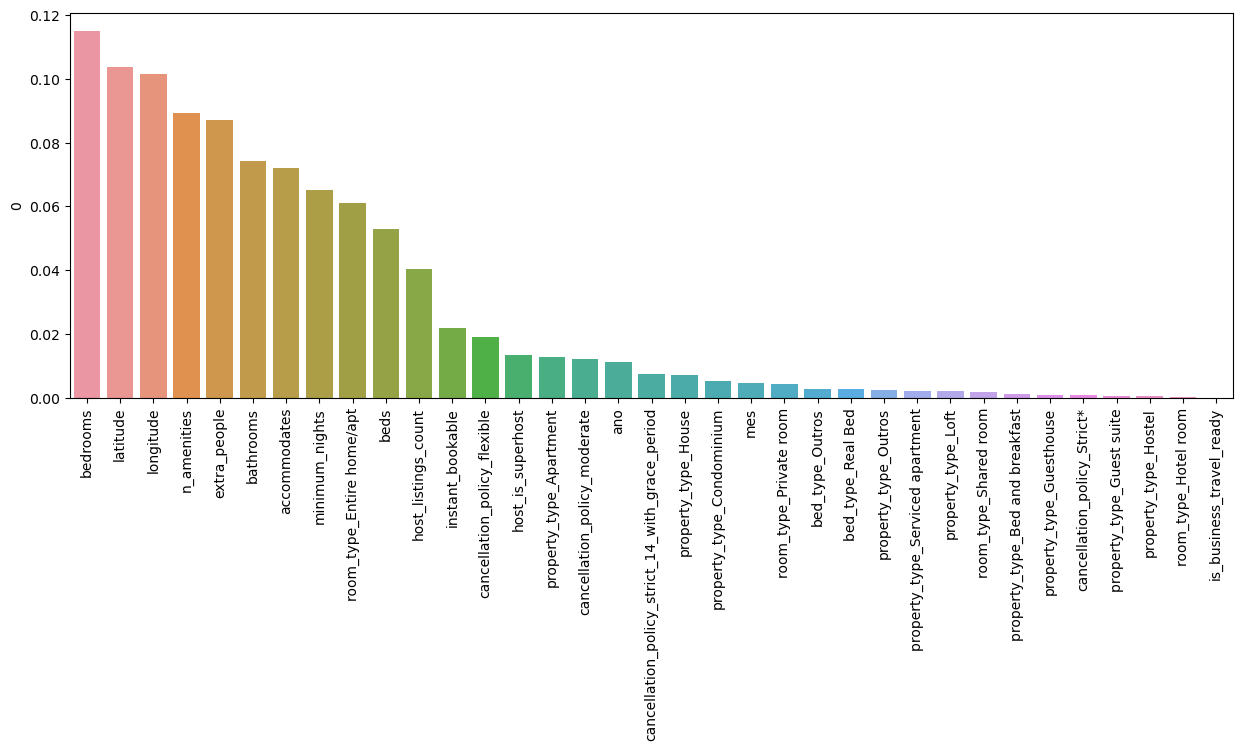

In [85]:
# Fazendo a análise gráfica das features / colunas com maior importância pro modelo
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

## 7) Ajustes e Melhorias no Melhor de Previsão de Resultados

**Método:**
- Ver quais features foram identificadas como menos importantes pelo modelo e podem ser retiradas
- A cada etapa / feature retirada, treinamos e testamos o modelo novamente, sempre comparando os resultados do modelo com o resultado do modelo original

***OBS**: A fim de reduzir o tamanho deste projeto postado no GitHub, não iremos treinar e testar o modelo a feature retirada. Isso já foi feito em outro notebook e os resultados já foram validados. Faremos esse processo de retreino reteste do modelo após os ajustes das features apenas uma única vez*

**Objetivo:**
- Encontrar uma possível melhoria no modelo (inclusive de precisão: aumento de R2 ou redução do RMSE)
- Ver se conseguimos chegar no mesmo resultado ou em um resultado muito próximo ao original com um modelo mais simples e rápido
- Fazemos outros testes que pensamos em fazer nas etapas anteriores do projeto (ex: excluir ou não uma coluna, excluir um não os outliers de uma feature)

1ª Pacote de Alterações a serem feitas na base de dados baseado na importância das features:
- Exclusão da feature 'is_business_travel_ready'
- Exclusão das features 'bed_type_Real_Bed' e 'bed_type_outros'
- Em relação a feature 'cancellation_policy' unifificarei as categorias 'strict_14_with_grace_period' e 'strict*
- Em relação a feature 'room_type', deixar apenas as categorias 'Entire home-apt', 'House' e as demais categorias deixarei como 'outros'
- Em relação a feature 'property_type', incluiremos na categoria 'Outros' as categorias 'Serviced apartment', 'Bed and breakfast', 'Guesthouse', 'Guest suite', 'Hostel', 'Hotel Room'

2ª Pacote de Alterações a serem feitas na base de dados baseado na importância das features:
- Trabalhar apenas com as 15 features com maior relevância para o modelo

In [86]:
base_airbnb2 = base_airbnb.copy()

In [87]:
base_airbnb2.columns

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'extra_people', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'ano', 'mes', 'n_amenities'],
      dtype='object')

In [88]:
# 1ª Alteração na base de dados
base_airbnb2 = base_airbnb2.drop('is_business_travel_ready', axis=1)

# 2ª Alteração na base de dados
base_airbnb2 = base_airbnb2.drop('bed_type', axis=1)

In [89]:
#3ª Alteração na base de dados 

print(base_airbnb2['cancellation_policy'].value_counts())

colunas_agrupar = ['strict_14_with_grace_period', 'Strict*']

for tipo_politica in colunas_agrupar:
    linhas = base_airbnb2['cancellation_policy'] == tipo_politica
    colunas = 'cancellation_policy'
    base_airbnb2.loc[linhas, colunas] = 'Strict**'

base_airbnb2['cancellation_policy'].value_counts()

cancellation_policy
flexible                       254039
strict_14_with_grace_period    189138
moderate                       104953
Strict*                          9510
Name: count, dtype: int64


cancellation_policy
flexible    254039
Strict**    198648
moderate    104953
Name: count, dtype: int64

In [90]:
# 4ª Alteração na base dos dados

print(base_airbnb2['room_type'].value_counts())

colunas_agrupar = ['Shared room', 'Private room', 'Hotel room']

for tipo_room in colunas_agrupar:
    linhas = base_airbnb2['room_type'] == tipo_room
    colunas = 'room_type'
    base_airbnb2.loc[linhas, colunas] = 'Outros'

base_airbnb2['room_type'].value_counts()

room_type
Entire home/apt    354633
Private room       190589
Shared room         11605
Hotel room            813
Name: count, dtype: int64


room_type
Entire home/apt    354633
Outros             203007
Name: count, dtype: int64

In [91]:
# 5ª Alteração na base dos dados
print(base_airbnb2['property_type'].value_counts())

colunas_agrupar = ['Hostel', 'Guest suite', 'Guesthouse', 'Bed and breakfast', 'Loft', 'Serviced apartment', 'Condominium']

for tipo_property in colunas_agrupar:
    linhas = base_airbnb2['property_type'] == tipo_property
    colunas = 'property_type'
    base_airbnb2.loc[linhas, colunas] = 'Outros'

base_airbnb2['property_type'].value_counts()

property_type
Apartment             441595
House                  50080
Condominium            23952
Loft                   11593
Serviced apartment     10453
Outros                  8495
Bed and breakfast       3424
Guest suite             3368
Hostel                  2665
Guesthouse              2015
Name: count, dtype: int64


property_type
Apartment    441595
Outros        65965
House         50080
Name: count, dtype: int64

#### Repetindo o processo de Encoding dos dados

In [92]:
base_airbnb_codificado2 = base_airbnb2.copy()          # Definido um segundo dataframe para fazer o processo de encoding.

colunas_tf = ['host_is_superhost', 'instant_bookable']
colunas_categorias = ['property_type', 'room_type', 'cancellation_policy']

for coluna_tratada in colunas_tf:
    base_airbnb_codificado2.loc[base_airbnb_codificado2[coluna_tratada]=='t', coluna_tratada] = 1
    base_airbnb_codificado2.loc[base_airbnb_codificado2[coluna_tratada]=='f', coluna_tratada] = 0

base_airbnb_codificado2 = pd.get_dummies(data=base_airbnb_codificado2, columns=colunas_categorias, dtype=int)

base_airbnb_codificado2.head()

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  mes n_amenities  \
1        1.0       2.0   2.0  270.0          51.0  ...    4          25   
3        1.0       1.0   2.0  161.0          45.0  ...    4          14   
4        1.0       1.0   2.0  222.0          68.0  ...    4          16   
5        1.5       1.0   2.0  308.0          86.0  ...    4          30   
6        1.0       1.0   2.0  219.0          80.0  ...    4          30   

   property_type_Apartment  property_type_House  property_type_Outros  \
1                        0                    0                     1   
3                        1                    0                     0   
4                        1                    0                     0   
5                        1                    0                     0   
6                        0                    0                     1   

   room_type_Entire home/apt  room_type_Outros  cancellation_policy_Strict**  \
1                          1                 0                             1   
3                          1                 0                             1   
4                          1                 0                             1   
5                          1                 0                             1   
6                          1                 0                             1   

   cancellation_policy_flexible  cancellation_policy_moderate  
1                             0                             0  
3                             0                             0  
4                             0                             0  
5                             0                             0  
6                             0                             0  

[5 rows x 23 columns]

In [93]:
base_airbnb_codificado2.columns

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment', 'property_type_House',
       'property_type_Outros', 'room_type_Entire home/apt', 'room_type_Outros',
       'cancellation_policy_Strict**', 'cancellation_policy_flexible',
       'cancellation_policy_moderate'],
      dtype='object')

#### Treinando e testando o modelo novamente

In [94]:
y2 = base_airbnb_codificado2['price']
X2 = base_airbnb_codificado2.drop('price', axis=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=10)

start_time = time.time()

modelo_ajustado = ExtraTreesRegressor()
modelo_ajustado.fit(X_train2, y_train2)
previsao_ajustada = modelo_ajustado.predict(X_test2)
print(avaliar_modelo('Modelo Extra Trees - 1º Ajuste do Modelo', y_test2, previsao_ajustada))

end_time = time.time()
print("Tempo de execução: {:.1f} segundos\n".format(end_time-start_time))

Modelo Modelo Extra Trees - 1º Ajuste do Modelo: 
R2: 97.60% 
RSME: 41.07
Tempo de execução: 274.0 segundos



#### Verificando quais features são mais importantes

0
bedrooms                      0.112243
latitude                      0.108208
longitude                     0.105497
n_amenities                   0.092076
extra_people                  0.087093
accommodates                  0.077494
bathrooms                     0.068805
minimum_nights                0.066095
beds                          0.054142
host_listings_count           0.041114
room_type_Entire home/apt     0.036864
room_type_Outros              0.031083
instant_bookable              0.022198
cancellation_policy_flexible  0.018154
host_is_superhost             0.013221
property_type_Apartment       0.012764
ano                           0.011750
cancellation_policy_Strict**  0.011570
cancellation_policy_moderate  0.010068
property_type_Outros          0.007911
property_type_House           0.006742
mes                           0.004909

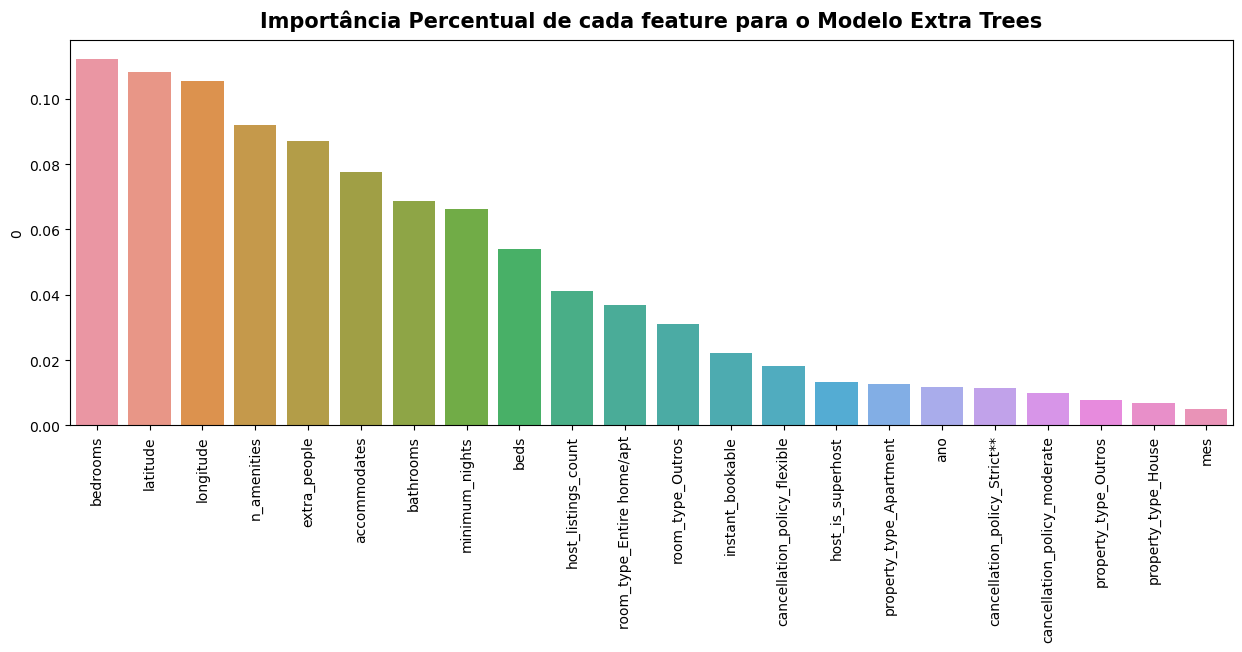

In [111]:
importancia_features2 = pd.DataFrame(modelo_ajustado.feature_importances_, X_train2.columns)
importancia_features2 = importancia_features2.sort_values(by=0, ascending=False)
display(importancia_features2)

plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features2.index, y=importancia_features2[0])
ax.tick_params(axis='x', rotation=90)

ax.set_title('Importância Percentual de cada feature para o Modelo Extra Trees', fontsize=15, fontweight='bold', pad=10)
plt.savefig('../relatorios/Importância cada feature para o Modelo Extra Trees.png', dpi=300, bbox_inches='tight')
plt.show()

#### Refazendo o modelo com as 15 features mais importantes

In [311]:
principais_features = list(importancia_features2.index[0:15])
principais_features

['bedrooms',
 'latitude',
 'longitude',
 'n_amenities',
 'extra_people',
 'accommodates',
 'bathrooms',
 'minimum_nights',
 'beds',
 'host_listings_count',
 'room_type_Entire home/apt',
 'room_type_Outros',
 'instant_bookable',
 'cancellation_policy_flexible',
 'host_is_superhost']

In [312]:
base_airbnb_codificado3 = base_airbnb_codificado2[principais_features]
base_airbnb_codificado3.head()

bedrooms   latitude  longitude  n_amenities  extra_people  accommodates  \
1       2.0 -22.965919 -43.178962           25          51.0             5   
3       1.0 -22.977117 -43.190454           14          45.0             3   
4       1.0 -22.983024 -43.214270           16          68.0             3   
5       1.0 -22.988165 -43.193588           30          86.0             3   
6       1.0 -22.981269 -43.190457           30          80.0             2   

   bathrooms  minimum_nights  beds  host_listings_count  \
1        1.0               4   2.0                  2.0   
3        1.0               4   2.0                  3.0   
4        1.0               2   2.0                  1.0   
5        1.5               2   2.0                  1.0   
6        1.0               3   2.0                  1.0   

   room_type_Entire home/apt  room_type_Outros instant_bookable  \
1                          1                 0                1   
3                          1                 0                0   
4                          1                 0                1   
5                          1                 0                0   
6                          1                 0                1   

   cancellation_policy_flexible host_is_superhost  
1                             0                 1  
3                             0                 0  
4                             0                 1  
5                             0                 1  
6                             0                 1

In [313]:
y3 = y2
X3 = base_airbnb_codificado3

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=10)

start_time = time.time()

modelo_ajustado2 = ExtraTreesRegressor()
modelo_ajustado2.fit(X_train3, y_train3)
previsao_ajustada2 = modelo_ajustado2.predict(X_test3)
print(avaliar_modelo('Modelo Extra Trees - 2º Ajuste do Modelo', y_test3, previsao_ajustada2))

end_time = time.time()
print("Tempo de execução: {:.1f} segundos\n".format(end_time-start_time))

Modelo Modelo Extra Trees - 2º Ajuste do Modelo: 
R2: 97.15% 
RSME: 44.74
Tempo de execução: 200.1 segundos



#### Comparativo do modelo original, com o 1º e 2º ajuste do modelo para escolher qual apresentou melhores resultados

In [314]:
print(avaliar_modelo('Modelo Extra Trees - Original', y_test, previsao))
print("--"*60)
print(avaliar_modelo('Modelo Extra Trees - 1º Ajuste do Modelo', y_test2, previsao_ajustada))
print("--"*60)
print(avaliar_modelo('Modelo Extra Trees - 2º Ajuste do Modelo', y_test3, previsao_ajustada2))

Modelo Modelo Extra Trees - Original: 
R2: 97.49% 
RSME: 42.00
------------------------------------------------------------------------------------------------------------------------
Modelo Modelo Extra Trees - 1º Ajuste do Modelo: 
R2: 97.59% 
RSME: 41.15
------------------------------------------------------------------------------------------------------------------------
Modelo Modelo Extra Trees - 2º Ajuste do Modelo: 
R2: 97.15% 
RSME: 44.74


**Conclusão**: O melhor modelo é aquele obtido após o 1º ajuste, pois é o que apresentou maior R2 e menor raíz do erro quadrático médio (RMSE). 

**OBS:** Ainda assim, a aplicação do modelo após 2º ajuste dos dados deve ser levada em consideração, pois não houve uma piora significativa dos erros R2 e RMSE, enquanto o tempo para executar o modelo foi menor e ao extrair esse modelo para um arquivo ".joblib" para uso em plataformas como do streamlit, por exemplo, tivemos um tamanho de arquivo 60% menor, além de possibilitar trabalhar com menos variáveis para simulações de resultados mais rápidas.

## 8) Deploy do Projeto

In [317]:
X2['price'] = y2             
X2.to_csv('../dados/dados_finais.csv')

As etapas de Deploy deste projeto estão descritas abaixo

- **Passo 1:** Criar arquivo ".joblib" para o modelo de machine learning criado nesse projeto
- **Passo 2:** Desenvolver código em arquivo ".py" para uso na plataforma Streamlit --> Esse arquivo foi criado e se chama "deploy_projet_airbnb_rj.py" estando salvo na mesma pasta deste notebook
- **Passo 3:** Importar Streamlit usando o arquivo ".py" criado para execução do modelo 
- **Passo 4:** Deploy feito - Basta simular as informações de entrada na plataforma do Streamlit para obter o valor da diária de um imóvel de um airbnb no Rio de Janeiro

#### Salvando o modelo de machine learning criado em um arquivo joblib

In [319]:
import joblib

joblib.dump(modelo_ajustado, '../modelos/modelo_extratrees.joblib')

['../modelos/modelo_extratrees.joblib']